In [1]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import fastmri
import torch
import xml.etree.ElementTree as etree
sys.path.append('../../src/')
from importlib import reload

from tqdm import tqdm
from fastmri.data import transforms as T
from fastmri.data.mri_data import et_query

# custom scripts
import mri_cs
from helpers import calculate_metrics

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

layout = go.Layout(template="plotly_dark")
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
py.init_notebook_mode()

In [2]:
DATA_PATH = '../../data/FastMRIData/singlecoil_train/'
FILE_SAMPLE = DATA_PATH + 'file1001287.h5'

hf = h5py.File(FILE_SAMPLE, mode='r')
list(hf.keys())
dict(hf.attrs)
n_slice = 20
crop_size = (320, 320)

et_root = etree.fromstring(hf["ismrmrd_header"][()])
# extract target image width, height from ismrmrd header
enc = ["encoding", "encodedSpace", "matrixSize"]
img_dims = (
    int(et_query(et_root, enc + ["x"])),
    int(et_query(et_root, enc + ["y"])),
)

volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[n_slice]
slice_kspace_tensor = T.to_tensor(volume_kspace[n_slice])

['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']

{'acquisition': 'CORPD_FBK',
 'max': 0.0004624860345092124,
 'norm': 0.1396935333699368,
 'patient_id': '6999a1ffb63756b29125b8779ce2c956620ff82c62700fe687d4a0d823b066b8'}

# Fully sampled slice 

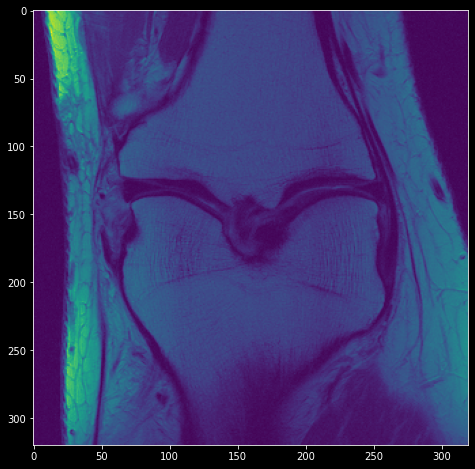

In [5]:
fully_sampled = hf["reconstruction_rss"][()][n_slice]
_ = plt.imshow(fully_sampled)

# Crop image for reconstruction

In [6]:
cropped_kspace = T.complex_center_crop(slice_kspace_tensor, crop_size)
cropped_kspace.shape

torch.Size([320, 320, 2])

# Create Mask

(320, 320)

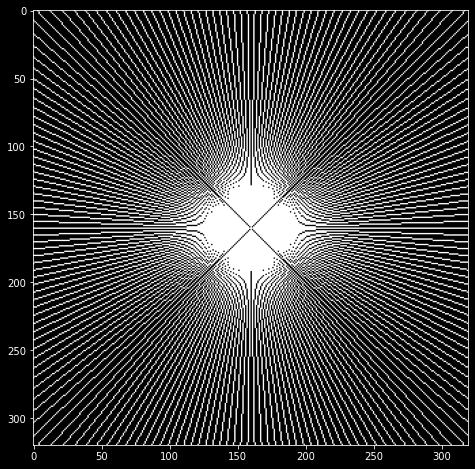

In [7]:
rows, cols, _ = cropped_kspace.shape
rows,cols

angles = np.linspace(0, np.pi, 100)
samples_rows, i, j = mri_cs.radial_lines_samples_rows(rows=rows, columns=cols, angles=angles)

I = np.zeros(shape=[rows * cols,])
I[samples_rows] = 1
I = np.reshape(I, [rows, cols], order="F").copy()
_ = plt.imshow(np.fft.fftshift(I), cmap='gray')

In [10]:
artificial_kspace = np.fft.fft2(fully_sampled)
def get_proportion(f_sampled, u_sampled):
    prop = np.array(u_sampled).flatten().shape[0] / np.array(f_sampled).flatten().shape[0]
    return prop
    
b = artificial_kspace.flatten()[samples_rows]
b.shape
get_proportion(cropped_kspace, b)
b

(29040,)

0.141796875

array([ 7.34057090e+00+0.j        ,  6.47224207e-01-0.56162807j,
       -2.39868951e-03-0.26333158j, ..., -3.51456000e-01+0.32635787j,
       -3.50168556e-01+0.21289064j,  4.88316455e-02+0.31372766j])

# FastMRI K-space

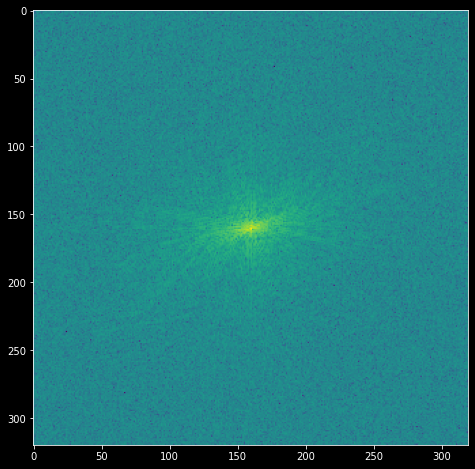

In [11]:
abs_kspace = fastmri.complex_abs(cropped_kspace)
_ = plt.imshow(np.log(abs_kspace + 1e-9))
# _ = plt.imshow(abs_kspace)

# Artificial k-space from FFT2

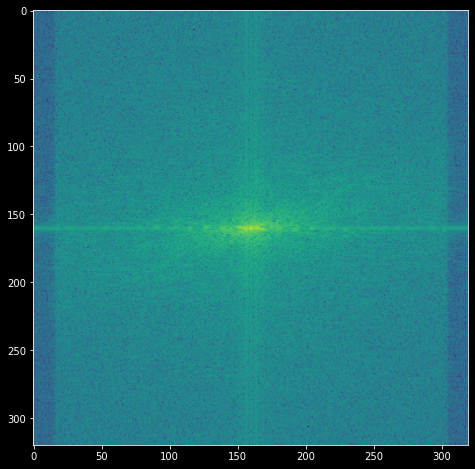

In [12]:
# _ = plt.imshow(np.abs(np.fft.fftshift(artificial_kspace)))
_ = plt.imshow(np.log(np.abs(np.fft.fftshift(artificial_kspace)) + 1e-9))

# Zero filled reconstruction

<module 'helpers' from '../../src/helpers.py'>

PSNR: 97.18460377657279
SSIM: 0.7658861253974969
SNR: 15.709744890958717
MSE: 1.9122277764829932e-10


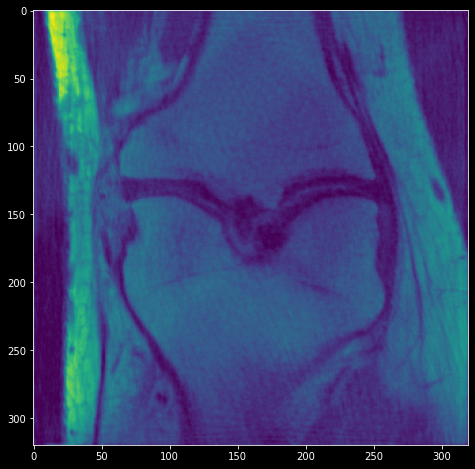

In [13]:
from helpers import zero_fill
import helpers
reload(helpers)

zero_filled = zero_fill(b, samples_rows, rows, cols)
# zero_filled = np.fft.fftshift(zero_filled)
_ = plt.imshow(np.abs(zero_filled))
_ = helpers.calculate_metrics(fully_sampled, np.abs(zero_filled))

# Prefiltering L1 Minimization

In [25]:
import mri_cs
reload(mri_cs)

filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

if isinstance(b, torch.Tensor):
    b = b.cpu().detach().numpy()
    
rows, cols = artificial_kspace.shape

tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30


recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, p=1, 
                            tol_cg=tol_cg, maxiter_cg=maxiter_cg, number_jobs=1,
                            maxiterperstage=maxiterperstage, verbose=False)

<module 'mri_cs' from '../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 17.44912576675415s


<module 'helpers' from '../../src/helpers.py'>

PSNR: 97.98114352506424
SSIM: 0.8125592197448284
SNR: 16.506284639450172
MSE: 1.5917895435296677e-10


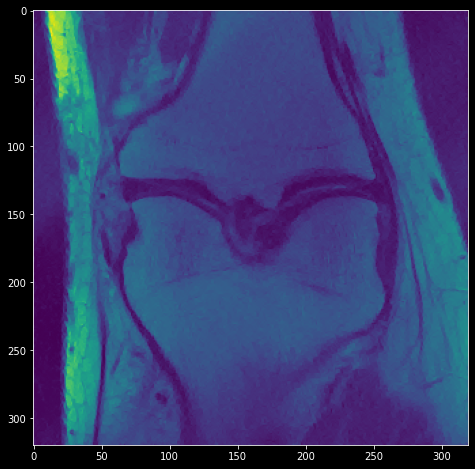

In [26]:
reload(helpers)

_ = plt.imshow(np.abs(recon))
_ = helpers.calculate_metrics(fully_sampled, np.abs(recon))